# Exercise - Kernel Authoring - Copy

In this exercise, we'll learn how to analyze and reason about the performance of CUDA kernels using the NVIDIA Nsight Compute profiler.

We'll look at a few different ways of writing a simple kernel that copies items from one array to another.

First, we need to make sure the Nsight Compute profiler, Nsightful, Numba CUDA, and CuPy are available in our notebook:

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"): # If running in Google Colab:
  !curl -s -L -O https://developer.nvidia.com/downloads/assets/tools/secure/nsight-systems/2025_3/NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb
  !sudo dpkg -i NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb > /dev/null
  !pip install "numba-cuda" "cupy-cuda12x" "nsightful[notebook] @ git+https://github.com/brycelelbach/nsightful.git" > /dev/null 2>&1
  os.environ["NUMBA_CUDA_ENABLE_PYNVJITLINK"] = "1"

Now, we'll write our first kernel. Each thread will copy `items_per_thread` items from the `src` array to the `dst` array. We'll set the number of threads per block to a constant, `threads_per_block`. We'll calculate how many blocks to launch based on `items_per_thread` and `threads_per_block`. We use `cuda.grid(1)` to get the unique global 1D index of each thread.

Each thread will copy a contiguous set of items, e.g. the items with indices `[base, base + items_per_thread)`:

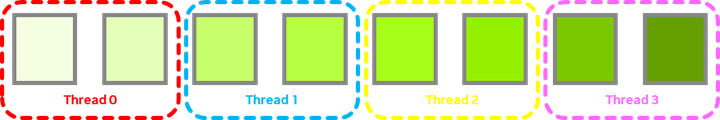

**NOTE: The next cell won't actually run any code, it will just write its contents to a file. This is necessary because we have to run the code with the Nsight Compute profiler.**

In [ ]:
%%writefile copy_blocked.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import sys
import os

threads_per_block = 256 if len(sys.argv) < 2 else int(sys.argv[1])
items_per_thread = 64 if len(sys.argv) < 3 else int(sys.argv[2])
total_items = 2**28 if len(sys.argv) < 4 else int(sys.argv[3])
blocks = int(total_items / (threads_per_block * items_per_thread))

src = cp.arange(total_items)
dst = cp.empty_like(src)

@cuda.jit
def copy_blocked(src, dst, items_per_thread):
 base = cuda.grid(1) * items_per_thread
 for i in range(items_per_thread):
   dst[base + i] = src[base + i]

copy_blocked[blocks, threads_per_block](src, dst, items_per_thread)
cp.testing.assert_array_equal(src, dst)

def launch():
  copy_blocked[blocks, threads_per_block](src, dst, items_per_thread)

if os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch() # `ncu` slows things down; so just launch once when running under it.
else:
  D = cpx.profiler.benchmark(launch, n_repeat=15, n_warmup=1).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Next, we'll actually run the code, by invoking the Nsight Compute `ncu` command line tool. The basic syntax for this tool is `ncu <ncu flags> <your program> <your program args>`, which will run `<your program> <your program args>` while gathering a profile on how your kernels are performing. We're passing it some flags that describe what data it should collect and where it should save the results.

There is an overhead to running code under the profiler. Your program may execute noticably slower.

When profiling and benchmarking, we need to run with a sufficient workload to get meaningful and representative results. If your runtime is too short, the profiler may not be able to report some metrics or the results may be inaccurate.

**NOTE: To modify and rerun the above code, you must execute the previous cell to write the file and this one to execute it.**

In [ ]:
!ncu -f --kernel-name regex:copy_blocked --set full -o copy_blocked python copy_blocked.py
copy_blocked_csv = !ncu --import copy_blocked.ncu-rep --csv

Let's take a look at the profiling report on the kernel. When you run the next cell, a number of tabs will be displayed. The first tab will have a summary of all of the Nsight recommendations and advisories. Subsequent tabs will have more detailed information on a particular area.

**TODO: Spend a few minutes reviewing the report. What stands out to you? Based on the information in the report, how can the kernel be improved?**

**EXTRA CREDIT: Download the [Nsight Compute GUI](https://developer.nvidia.com/nsight-compute) and open the report in it to see even more information.**

In [ ]:
import nsightful

nsightful.display_ncu_csv_in_notebook(copy_blocked_csv)

**TODO: Now try to write a better version of our copy kernel.**

As a hint, given that this kernel does no compute and just moves data, our memory access patterns are probably important!

Instead of using the `cuda.grid` utility, you may want to use the hierachical coordinates of our thread to calculate the index:

- `cuda.blockDim.x`: The number of threads per block.
- `cuda.blockIdx.x`: The global index of the current thread block.
- `cuda.threadIdx.x`: The local index of the current thread within this block.

In [ ]:
%%writefile copy_optimized.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import sys
import os

threads_per_block = 256 if len(sys.argv) < 2 else int(sys.argv[1])
items_per_thread = 64 if len(sys.argv) < 3 else int(sys.argv[2])
total_items = 2**28 if len(sys.argv) < 4 else int(sys.argv[3])
blocks = int(total_items / (threads_per_block * items_per_thread))

src = cp.arange(total_items)
dst = cp.empty_like(src)

@cuda.jit
def copy_optimized(src, dst, items_per_thread):
  TODO() # TODO: You need to implement this kernel! DELETE THIS LINE.

copy_optimized[blocks, threads_per_block](src, dst, items_per_thread)
cp.testing.assert_array_equal(src, dst)

def launch():
  copy_optimized[blocks, threads_per_block](src, dst, items_per_thread)

if os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch() # `ncu` slows things down; so just launch once when running under it.
else:
  D = cpx.profiler.benchmark(launch, n_repeat=15, n_warmup=1).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Now, let's make sure our code works:

In [ ]:
!python copy_optimized.py

Before we look at the report, let's compare the runtimes of both versions:

In [ ]:
copy_blocked_duration   = !python copy_blocked.py
copy_optimized_duration = !python copy_optimized.py
speedup = float(copy_blocked_duration[0].split()[0]) / float(copy_optimized_duration[0].split()[0])

print(f"copy_blocked:   {copy_blocked_duration[0]}")
print(f"copy_optimized: {copy_optimized_duration[0]}")
print(f"copy_optimized speedup over copy_blocked: {speedup:.2f}")

Hopefully you see quite a speedup! Now let's profile the optimized variant:

In [ ]:
!ncu -f --kernel-name regex:copy_optimized --set full -o copy_optimized python copy_optimized.py
copy_optimized_csv = !ncu --import copy_optimized.ncu-rep --csv

Now let's look at the report to better understand what's going on.

In [ ]:
nsightful.display_ncu_csv_in_notebook(copy_optimized_csv)

**EXTRA CREDIT: Experiment with different problem sizes, threads per block, and items per thread. You can pass them as command line arguments to the Python scripts. If you're feeling really ambitious, do a parameter sweep to study the impact these knobs have on performance.**